In [1]:
# By Matt Stirling
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from ast import literal_eval

pd.set_option('display.width', 1400)

In [2]:
def format_text(text, line_width=120):
    lines = []
    line = ''
    for word in text.split():
        if len(line) == 0:
            line = word
        elif len(line + ' ' + word) > line_width:
            lines.append(line)
            line = ''
        else:
            line += ' ' + word
    lines.append(line)
    return '\n'.join(lines)

In [3]:
# Load recipes into dataframe
converters = { k: literal_eval for k in ['tags', 'ingredients', 'steps', 'nutrition'] } # for evaluating strings as arrays (eg. tags)
df_recipes = pd.read_csv('dataset/RAW_recipes.csv', converters=converters)
df_recipes.set_index('id', inplace=True)
df_recipes['n_tags'] = df_recipes['tags'].apply( lambda tags: len(tags) ) # add n_tags column
df_recipes.head()

,name,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,n_tags
id,,,,,,,,,,,,
137739,arriba baked winter squash mexican style,55,47892,2005-09-16,"[60-minutes-or-less, time-to-make, course, mai...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"[make a choice and proceed with recipe, depend...",autumn is my favorite time of year to cook! th...,"[winter squash, mexican seasoning, mixed spice...",7,20
31490,a bit different breakfast pizza,30,26278,2002-06-17,"[30-minutes-or-less, time-to-make, course, mai...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"[preheat oven to 425 degrees f, press dough in...",this recipe calls for the crust to be prebaked...,"[prepared pizza crust, sausage patty, eggs, mi...",6,20
112140,all in the kitchen chili,130,196586,2005-02-25,"[time-to-make, course, preparation, main-dish,...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"[brown ground beef in large pot, add chopped o...",this modified version of 'mom's' chili was a h...,"[ground beef, yellow onions, diced tomatoes, t...",13,9
59389,alouette potatoes,45,68585,2003-04-14,"[60-minutes-or-less, time-to-make, course, mai...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,[place potatoes in a large pot of lightly salt...,"this is a super easy, great tasting, make ahea...","[spreadable cheese with garlic and herbs, new ...",11,30
44061,amish tomato ketchup for canning,190,41706,2002-10-25,"[weeknight, time-to-make, course, main-ingredi...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,"[mix all ingredients& boil for 2 1 / 2 hours ,...",my dh's amish mother raised him on this recipe...,"[tomato juice, apple cider vinegar, sugar, sal...",8,21


In [4]:
# Load interactions (user ratings) into dataframe
df_interact = pd.read_csv('dataset/RAW_interactions.csv')
df_interact.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


#### **1. Initial Data Exploration:** Explore the distribution of recipes based on key features such as minutes, tags, n_steps, and n_ingredients, and visualize the distribution of recipes for each of these features. 

In [5]:
mins = sorted(df_recipes['minutes'], reverse=1)
print(f'{len(mins):_}')
print('Recipes with 0 minutes:', len([ x for x in mins if x == 0 ]))

231_637
Recipes with 0 minutes: 1094


In [6]:
mins_filtered = [x for x in df_recipes['minutes'] if 0 < x < 60*4]
print(f'{len(mins_filtered)} recipes within 4 hours')

217198 recipes within 4 hours


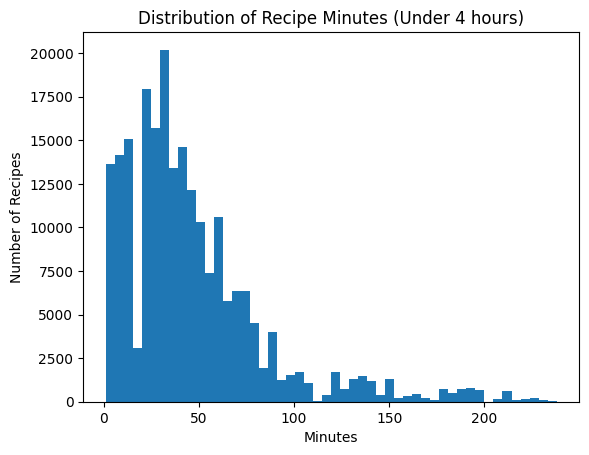

In [7]:
plt.hist(mins_filtered, bins=50)
plt.title('Distribution of Recipe Minutes (Under 4 hours)')
plt.xlabel('Minutes')
plt.ylabel('Number of Recipes')
plt.show()

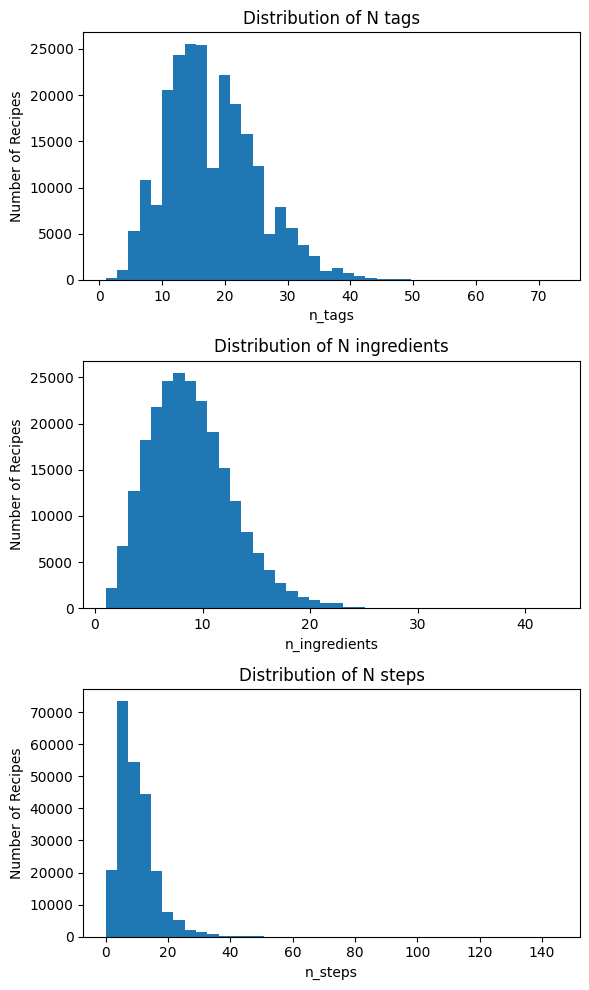

In [8]:
fig, ax = plt.subplots(3, 1, figsize=(6, 10))
for i, key in enumerate(['n_tags', 'n_ingredients', 'n_steps']):
    ax[i].hist(df_recipes[key], bins=40)
    ax[i].set_title(f'Distribution of {key.replace("_", " ").capitalize()}')
    ax[i].set_xlabel(key)
    ax[i].set_ylabel('Number of Recipes')
plt.tight_layout()
plt.show()

#### 2. **User Profile Generation:** Using the two datasets, RAW_recipes.csv and RAW_interactions.csv, create a new dataset named User_Data.csv, where each row corresponds to a user in the system. The columns should include rated_recipes (a list of all recipes rated by the user), ingredients (a list of all ingredients in the recipes rated by the user), and rating_list (the list of ratings given by the user). Based on this generated user profile, explore the distribution of users across key features such as the number of rated items, the total number of ingredients per user, and the average of recorded ratings. Visualize the distribution of users for each of these features. 

In [9]:
def create_userdata_dataframe(ratings):
    users = {}
    total_ratings = len(ratings)
    for i, row in enumerate(ratings.itertuples()):
        print('\rHandling interaction {:_} ({:.1f}%)'.format(i+1, (i+1)/total_ratings*100), end='')
        obj = users.get(row.user_id)
        if obj == None:
            obj = {'user_id': row.user_id, 'rated_recipes': [], 'ingredients': [], 'rating_list': []}
        obj['rated_recipes'].append(row.recipe_id)
        obj['rating_list'].append(row.rating)
        recipe = df_recipes.loc[row.recipe_id] # get recipe by its id
        obj['ingredients'].extend(recipe.ingredients)
        obj['ingredients'] = list(set(obj['ingredients']))
        users[row.user_id] = obj
        # if i >= 100_000: break
    print('\nDone.')
    df_userdata = pd.DataFrame(users.values())
    df_userdata.set_index('user_id', inplace=True)
    return df_userdata

In [10]:
# Create OR load userdata dataframe
userdata_fn = 'dataset/User_Data.csv'
if not os.path.exists(userdata_fn):
    print('Creating df_userdata ...')
    df_userdata = create_userdata_dataframe(df_interact)
    df_userdata.to_csv(userdata_fn)
else:
    print('Loading df_userdata ...')
    converters = { k: literal_eval for k in ['rated_recipes', 'ingredients', 'rating_list'] }
    df_userdata = pd.read_csv(userdata_fn, converters=converters)
df_userdata.head()

Creating df_userdata ...
Handling interaction 1_132_367 (100.0%)
Done.


,rated_recipes,ingredients,rating_list
user_id,,,
38094,"[40893, 16954, 40753, 34513, 69545, 49064, 800...","[anchovy fillets, rice, cashews, broccoli cole...","[4, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, ..."
1293707,"[40893, 134316, 39446, 253891, 204257, 99564, ...","[onions, condensed cream of chicken soup, corn...","[5, 5, 5, 5, 0, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."
8937,"[44394, 39230, 44793, 20128, 33990, 43762, 945...","[onions, condensed cream of chicken soup, froz...","[4, 4, 4, 5, 5, 4, 5, 4, 5, 4, 4, 4, 5, 4, 4, ..."
126440,"[85009, 379639, 379102, 45539, 53594, 210456, ...","[non-fat powdered milk, corn, kalamata olives,...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, ..."
57222,"[85009, 434181, 34233, 443705, 122826, 112378,...","[vodka, halloumi cheese, sesame oil, candied g...","[5, 5, 4, 5, 4, 5, 4, 4, 4, 4, 5, 0, 4, 5, 5, ..."


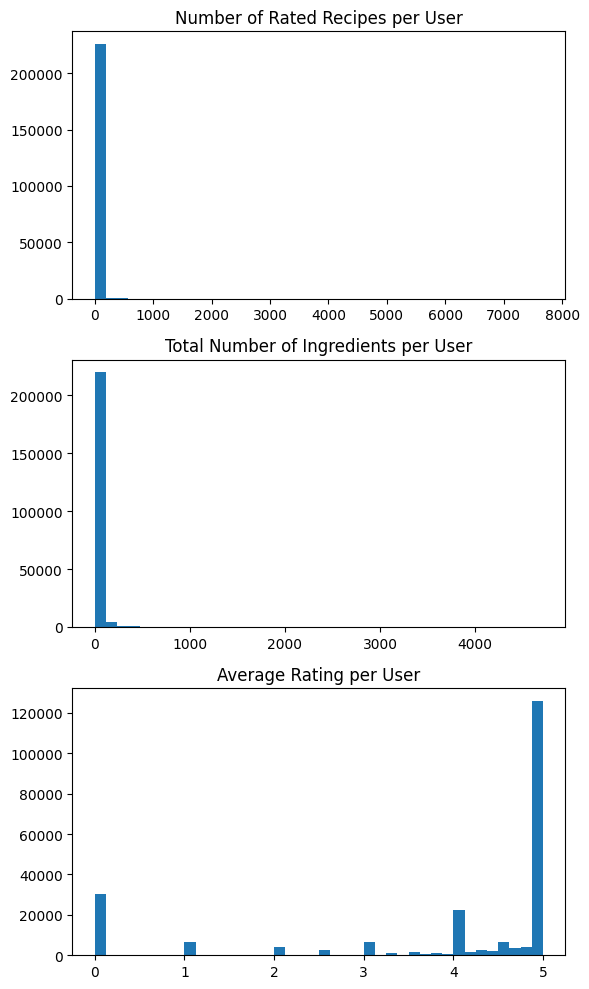

In [13]:
fig, ax = plt.subplots(3, 1, figsize=(6, 10))

# Distribution of number of rated recipes per user
ax[0].hist(df_userdata['rated_recipes'].apply(len), bins=40)
ax[0].set_title('Number of Rated Recipes per User')

# Distribution of total number of ingredients per user
ax[1].hist(df_userdata['ingredients'].apply(len), bins=40)
ax[1].set_title('Total Number of Ingredients per User')

# Distribution of average user ratings
ax[2].hist(df_userdata['rating_list'].apply(lambda x: sum(x)/len(x) if len(x) > 0 else 0), bins=40)
ax[2].set_title('Average Rating per User')

plt.tight_layout()
plt.show()

#### 3. Sentiment Analysis on User Reviews: Perform Sentiment Analysis on the user reviews using pre-trained models (e.g.,VADER, TextBlob, or BERT) to analyzes the sentiment polarity of each review and categorizes them into positive, neutral, or negative sentiments.

In [5]:
from textblob import TextBlob

In [6]:
def get_sentiment_textblob(text, buffer = 0):
    if isinstance(text, str):
        analysis = TextBlob(text)

        if analysis.sentiment.polarity > buffer:
            return 'positive'
        elif analysis.sentiment.polarity < -buffer:
            return 'negative'
        
    return 'neutral'

In [7]:
#df_interact['sentiment'] = df_interact['review'].apply(get_sentiment_textblob)
df_interact['sentiment'] = df_interact['review'][:10000].apply(get_sentiment_textblob)
df_interact.head(15)

,user_id,recipe_id,date,rating,review,sentiment
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...,positive
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall...",positive
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...,positive
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...,positive
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin...",negative
5,52282,120345,2005-05-21,4,very very sweet. after i waited the 2 days i b...,positive
6,124416,120345,2011-08-06,0,"Just an observation, so I will not rate. I fo...",positive
7,2000192946,120345,2015-05-10,2,This recipe was OVERLY too sweet. I would sta...,positive
8,76535,134728,2005-09-02,4,Very good!,positive
9,273745,134728,2005-12-22,5,Better than the real!!,positive


#### 4. Sentiment polarity between different recipe groups: Explore the average sentiment for different recipes and tags by analyzing the sentiment polarity of user reviews. Visualize the results to identify any interesting patterns or findings regarding recipes or tags with notable sentiment polarity. Discuss any significant insights, such as recipes or tags that show strong positive or negative sentiment trends.

In [8]:
#Convert sentiment to numeric values
sentiment_mapping = {
    'positive': 1,
    'neutral': 0,
    'negative': -1
}
df_interact['sentiment_numeric'] = df_interact['sentiment'].map(sentiment_mapping)

In [9]:
#Average sentiment for each recipe
df_recipe_sentiment = df_interact.groupby('recipe_id')['sentiment_numeric'].mean().reset_index()
sentiment_map = df_recipe_sentiment.set_index('recipe_id')['sentiment_numeric'].to_dict()
df_recipes['average_sentiment'] = df_recipes.index.map(sentiment_map)

In [10]:
#Average sentiment for each tag
def calculate_tag_sentiment(df_interact, df_recipes):
    df_tags_exploded = df_recipes[['tags']].explode('tags').reset_index()
    df_tags_sentiment = df_interact[['recipe_id', 'sentiment_numeric']].merge(df_tags_exploded, left_on='recipe_id', right_on='id')
    return df_tags_sentiment.groupby('tags')['sentiment_numeric'].mean().reset_index()

df_tag_sentiment = calculate_tag_sentiment(df_interact, df_recipes)

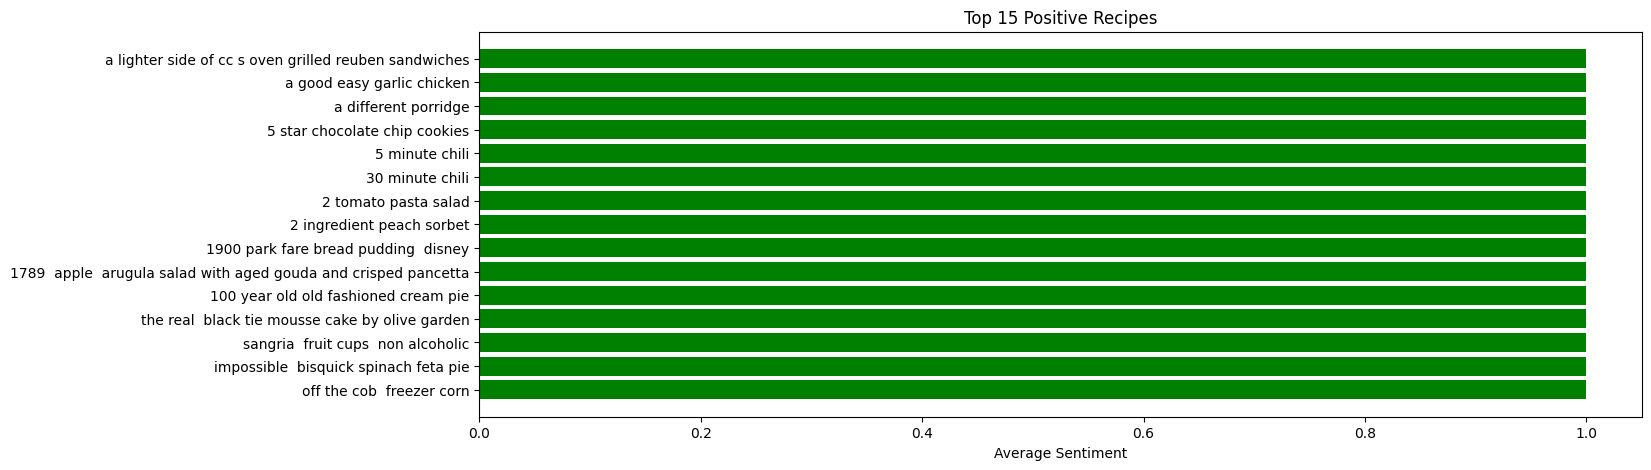

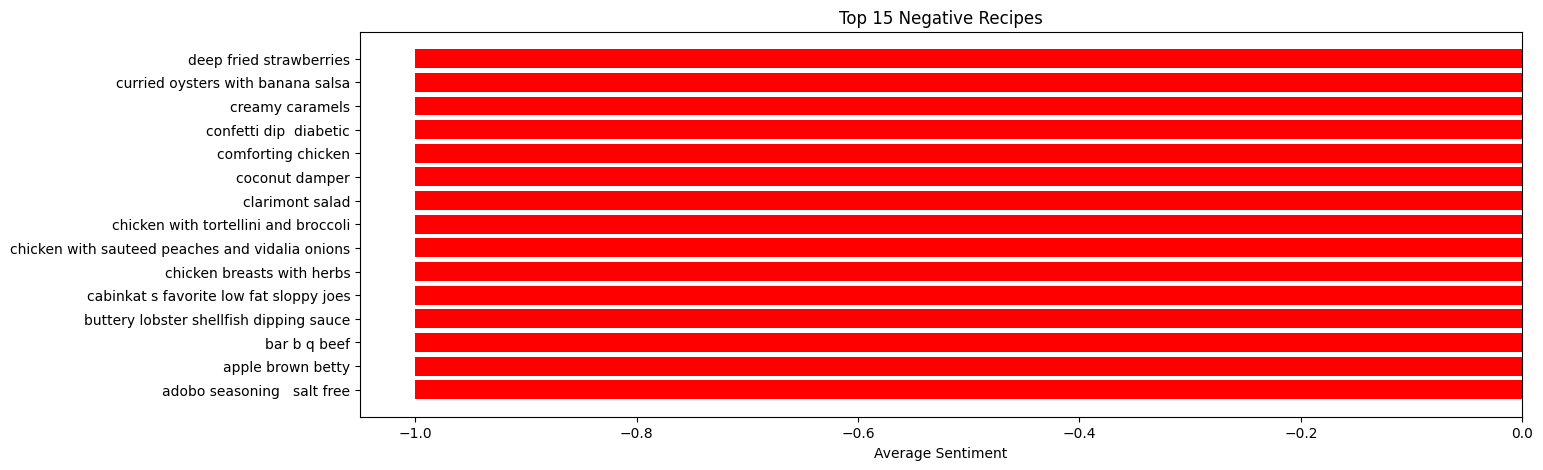

In [12]:
# Top 15 recipes with most positive sentiment
top_positive_recipes = df_recipes.nlargest(15, 'average_sentiment')

# Top 15 recipes with most negative sentiment
top_negative_recipes = df_recipes.nsmallest(15, 'average_sentiment')

plt.figure(figsize=(15, 5))
plt.barh(top_positive_recipes['name'], top_positive_recipes['average_sentiment'], color='green')
plt.title('Top 15 Positive Recipes')
plt.xlabel('Average Sentiment')
plt.show()

plt.figure(figsize=(15, 5))
plt.barh(top_negative_recipes['name'], top_negative_recipes['average_sentiment'], color='red')
plt.title('Top 15 Negative Recipes')
plt.xlabel('Average Sentiment')
plt.show()


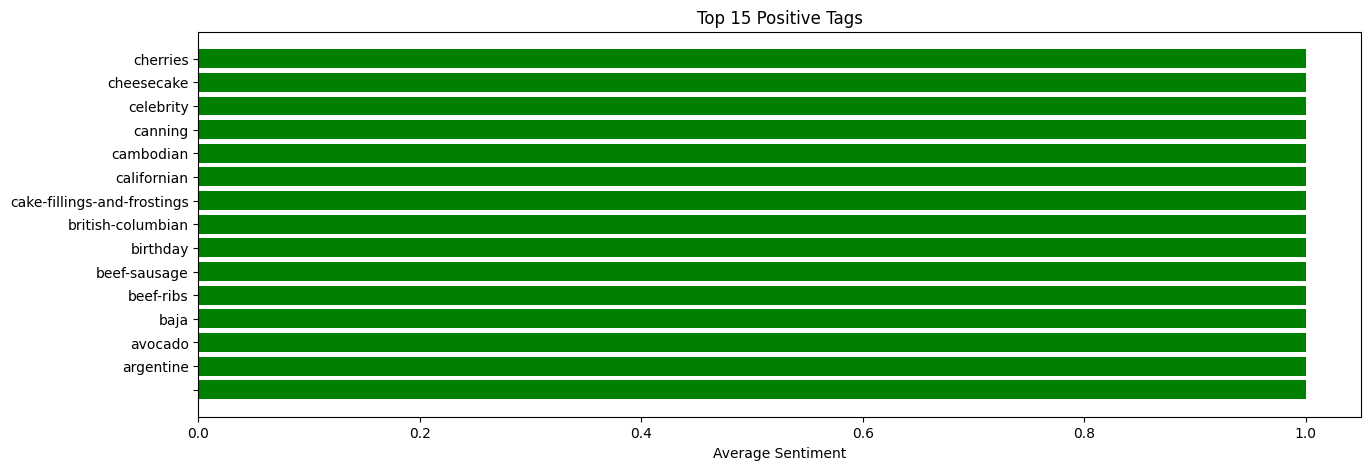

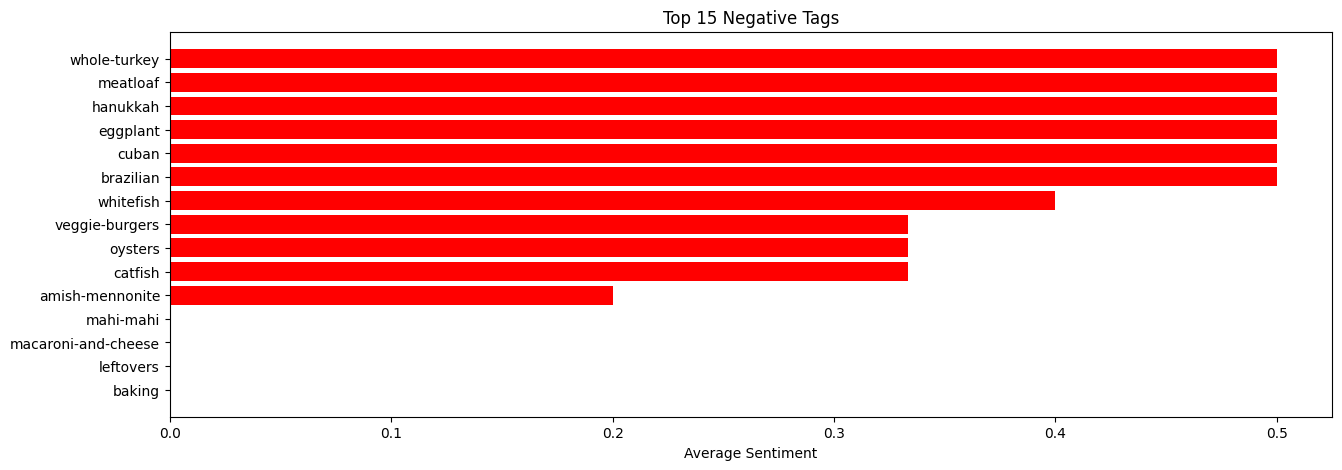

In [13]:
# Top 15 tags with most positive and most negative sentiment
top_positive_tags = df_tag_sentiment.nlargest(15, 'sentiment_numeric')
top_negative_tags = df_tag_sentiment.nsmallest(15, 'sentiment_numeric')

plt.figure(figsize=(15, 5))
plt.barh(top_positive_tags['tags'], top_positive_tags['sentiment_numeric'], color='green')
plt.title('Top 15 Positive Tags')
plt.xlabel('Average Sentiment')
plt.show()

plt.figure(figsize=(15, 5))
plt.barh(top_negative_tags['tags'], top_negative_tags['sentiment_numeric'], color='red')
plt.title('Top 15 Negative Tags')
plt.xlabel('Average Sentiment')
plt.show()

In [15]:
print("Top 15 positive recipes:")
print(top_positive_recipes[['name', 'average_sentiment']])

print("\nTop 15 negative recipes:")
print(top_negative_recipes[['name', 'average_sentiment']])

print("\nTop 15 positive tags:")
print(top_positive_tags[['tags', 'sentiment_numeric']])

print("\nTop 15 negative tags:")
print(top_negative_tags[['tags', 'sentiment_numeric']])

Top 15 positive recipes:
                                                     name  average_sentiment
id                                                                          
97052                           off the cob  freezer corn                1.0
194665              impossible  bisquick spinach feta pie                1.0
232044                 sangria  fruit cups  non alcoholic                1.0
392181    the real  black tie mousse cake by olive garden                1.0
129377               100 year old old fashioned cream pie                1.0
294427  1789  apple  arugula salad with aged gouda and...                1.0
240311               1900 park fare bread pudding  disney                1.0
400243                          2 ingredient peach sorbet                1.0
20930                                2 tomato pasta salad                1.0
446919                                    30 minute chili                1.0
116672                                     5 minute

##### 5. **Tag- and ingredients-based Recipe Similarity Calculation:** Propose a method for calculating the similarity between different recipes, such as TF-IDF, Jaccard, Levenshtein Distance, Semantic Similarity, or Doc2Vec, by considering recipes' ingredients and tags. Next, calculate the recipe similarities based on their tags and ingredients using the selected method. 

In [16]:
# Functions for performing jaccard similarity between recipes

def jaccard_similarity(s1, s2):
    intersect = set([ x for x in s1 + s2 if (x in s1 and x in s2) ])
    union = list(set(s1 + s2))
    return len(intersect) / len(union)

# Given a target set, get array of jaccard similarity for all sets
def jaccard_similarity_array(target_set, sets):
    return [ jaccard_similarity(target_set, set_cmp) for set_cmp in sets ]

def get_similar_items_tags(tags_corpus, ingredients_corpus, target_i, top_n=5):
    target_tags, target_ingredients = tags_corpus[target_i], ingredients_corpus[target_i]
    sims_tags = jaccard_similarity_array(target_tags, tags_corpus)
    sims_ingredients = jaccard_similarity_array(target_ingredients, ingredients_corpus)
    sims_ave = [ (sim1 + sim2) / 2 for sim1, sim2 in zip(sims_tags, sims_ingredients) ]
    sims_items = [ (i, sim) for i, sim in enumerate(sims_ave) ]
    sims_items.sort(reverse=True, key=lambda item: item[1])
    return sims_items[1:top_n+1]

In [17]:
# Get list (corpus) of recipe tags and ingredients
n = None # Set to None to load whole dataframe
tags_corpus =        list(df_recipes.head(n)['tags'].values)
ingredients_corpus = list(df_recipes.head(n)['ingredients'].values)

In [18]:
# Get most similar items
target_i = 425
target_recipe = df_recipes.iloc[target_i]
top_results = get_similar_items_tags(tags_corpus, ingredients_corpus, target_i, top_n=5)
print('TARGET RECIPE: "{}" (index: {:_}):'.format(target_recipe['name'].replace('  ', ' - ').title(), target_i))
print('      TAGS: {}'.format(', '.join(sorted(tags_corpus[target_i]))))
print('      INGS: {}'.format(', '.join(sorted(ingredients_corpus[target_i]))))
print('\nRECOMMENDATIONS:')
for j, (i, sim) in enumerate(top_results):
    recipe = df_recipes.iloc[i]
    print('\n  {:>2}: SIM: {:.3f}   NAME: "{}"  (index: {:_})'.format( j+1, sim, recipe['name'].replace('  ', ' - ').title(), i))
    print('      TAGS: {}'.format(', '.join(sorted(tags_corpus[i]))))
    print('      INGS: {}'.format(', '.join(sorted(ingredients_corpus[i]))))

TARGET RECIPE: "Indian - Macaroni And Cheese" (index: 425):
      TAGS: 30-minutes-or-less, 5-ingredients-or-less, american, beginner-cook, cheese, course, cuisine, dietary, easy, eggs-dairy, elbow-macaroni, high-calcium, high-in-something, inexpensive, main-dish, main-ingredient, midwestern, north-american, one-dish-meal, pasta, pasta-rice-and-grains, preparation, side-dishes, time-to-make
      INGS: cheese, elbow macaroni, milk, salt and pepper

RECOMMENDATIONS:

   1: SIM: 0.620   NAME: "Baked Mac And Cheese"  (index: 14_510)
      TAGS: 4-hours-or-less, cheese, course, eggs-dairy, elbow-macaroni, main-dish, main-ingredient, pasta, pasta-rice-and-grains, preparation, side-dishes, time-to-make
      INGS: butter, cheese, elbow macaroni, milk, salt and pepper

   2: SIM: 0.611   NAME: "Super Creamy And Cheesy Mac And Cheese"  (index: 203_923)
      TAGS: 15-minutes-or-less, american, cheese, course, cuisine, dietary, easy, eggs-dairy, elbow-macaroni, lunch, main-ingredient, north-ame

#### **6. Description-based Recipe Similarity Calculation:** Repeat Task 5 for recipe similarity calculation based on the descriptions of each recipe. 

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

In [20]:
STOPWORDS = list(nltk.corpus.stopwords.words('english'))
STEMMER = nltk.stem.snowball.SnowballStemmer('english')
LEMMATIZER = nltk.stem.WordNetLemmatizer()

def text_preprocessor(document):
    tokens = []
    for sentence in sent_tokenize(document.lower()):
        words = word_tokenize(sentence)
        words = [ word for word in words if (word.isalpha() and word not in STOPWORDS) ]
        words = [ STEMMER.stem(word) for word in words ]
        words = [ LEMMATIZER.lemmatize(word, pos="v") for word in words ]
        tokens.extend(words)
    return ' '.join(tokens)

In [21]:
def get_similar_items_TFIDF(matrix, target_i, top_n=10):
    target_vector = matrix[target_i]
    cosine_sims = cosine_similarity(target_vector, matrix)[0]
    sims_items = [ (i, sim) for i, sim in enumerate(cosine_sims) ]
    sims_items.sort(reverse=True, key=lambda item: item[1])
    return sims_items[1:top_n+1]

In [22]:
# Train TFIDF model on recipe descriptions
descriptions = list(df_recipes.head(10000)['description'].fillna('').values)

desc_tfidf = TfidfVectorizer(preprocessor=text_preprocessor, ngram_range=(1, 2))
desc_tfidf_matrix = desc_tfidf.fit_transform(descriptions)

In [23]:
# Get most similar items
target_i = 425
target_recipe = df_recipes.iloc[target_i]
top_results = get_similar_items_TFIDF(desc_tfidf_matrix, target_i, top_n=5)
print('TARGET RECIPE:')
print('"{}" (index: {:_}):'.format(target_recipe['name'].replace('  ', ' - ').title(), target_i))
print(format_text(target_recipe['description']))
print('\nRECOMMENDATIONS:')
for j, (i, sim) in enumerate(top_results):
    recipe = df_recipes.iloc[i]
    print('\n  {:>2}: SIM: {:.3f}   NAME: "{}"  (index: {:_})'.format( j+1, sim, recipe['name'].replace('  ', ' - ').title(), i))
    print(format_text(recipe['description']))

TARGET RECIPE:
"Indian - Macaroni And Cheese" (index: 425):
for those of us who get gov't food. its is the easiest and simplest macaroni and cheese recipes.

RECOMMENDATIONS:

   1: SIM: 0.179   NAME: "All American Macaroni And Cheese"  (index: 3_303)
this is very good homemade macaroni and cheese if you don't have a lot of time on your hands.

   2: SIM: 0.146   NAME: "15 Minute Chili"  (index: 949)
this is a recipe for healthier chili that i got from sparkpeople.com, a food tracking site.

   3: SIM: 0.137   NAME: "30 Minute Turkey Chili"  (index: 1_395)
from food network.com.

   4: SIM: 0.132   NAME: "Asian Cole Slaw With Tofu"  (index: 9_214)
i got this from the food network, courtesy tori ritchie. yum!

   5: SIM: 0.123   NAME: "Apple White Cheddar And Gruyere Macaroni -  Cheese"  (index: 7_445)
this is the 2006 winning recipe for tillamook macaroni & cheese cook-off by tim hutchinson of seattle, wa. it is
delicious!


#### 8. Recipe Clustering: Based on the recipe similarities calculated in the previous task of 5 and 6 (Content and Review), apply a suitable clustering algorithm (e.g., K-Means, DBSCAN, or Agglomerative Clustering) to group similar recipes. Perform the clustering task separately for ingredients and descriptions and compare the clustering outcomes.

In [24]:
from sklearn.cluster import MiniBatchKMeans
from scipy.sparse import lil_matrix
from joblib import Parallel, delayed

In [25]:
def compute_jaccard(i, j):
    return jaccard_similarity(tags_corpus[i], tags_corpus[j])

def create_sparse_jaccard_matrix(tags_corpus):
    n = len(tags_corpus)
    jaccard_matrix = lil_matrix((n, n), dtype=float)

    results = Parallel(n_jobs=-1)(
        delayed(compute_jaccard)(i, j) for i in range(n) for j in range(i + 1, n)
    )
    
    index = 0
    for i in range(n):
        for j in range(i + 1, n):
            jaccard_matrix[i, j] = results[index]
            jaccard_matrix[j, i] = results[index]
            index += 1

    return jaccard_matrix

def perform_kmeans_clustering(data, n_clusters):
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=100)
    labels = kmeans.fit_predict(data)
    return labels

In [26]:
max_recipes = 1000
n_clusters = 5

tags_corpus = list(df_recipes.head(max_recipes)['tags'].values)

jaccard_similarity_matrix = create_sparse_jaccard_matrix(tags_corpus)

jaccard_labels = perform_kmeans_clustering(jaccard_similarity_matrix.toarray(), n_clusters)

df_recipes['jaccard_cluster'] = pd.Series(index=df_recipes.index[:max_recipes], data=jaccard_labels)

descriptions = list(df_recipes.head(max_recipes)['description'].fillna('').values)
desc_tfidf = TfidfVectorizer(preprocessor=text_preprocessor, ngram_range=(1, 2))
desc_tfidf_matrix = desc_tfidf.fit_transform(descriptions)

tfidf_labels = perform_kmeans_clustering(desc_tfidf_matrix.toarray(), n_clusters)

df_recipes['tfidf_cluster'] = pd.Series(index=df_recipes.index[:max_recipes], data=tfidf_labels)

/home/pau/Uni/Oulu/NLP/ntp/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/home/pau/Uni/Oulu/NLP/ntp/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


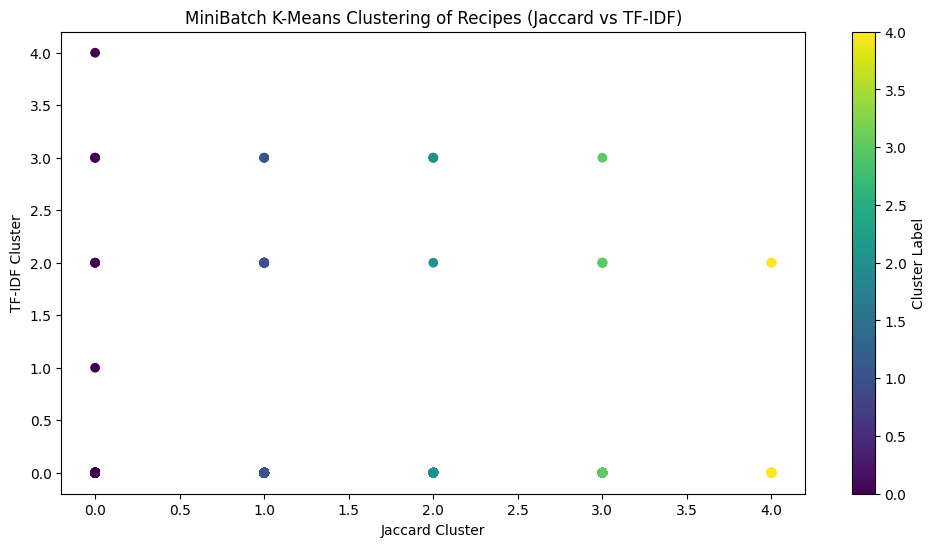


Cluster 0:
id
   boat house  collard greens
      calm your nerves  tonic
         grilled  ranch bread
i yam what i yam two  muffins
    i yam what i yam  muffins

Cluster 1:
id
arriba   baked winter squash mexican style
          a bit different  breakfast pizza
                        alouette  potatoes
        amish  tomato ketchup  for canning
                     aww  marinated olives

Cluster 2:
id
         apple a day  milk shake
     berry  good sandwich spread
                  chinese  candy
 easiest ever  hollandaise sauce
emotional balance  spice mixture

Cluster 3:
id
          all in the kitchen  chili
   chicken lickin  good  pork chops
            crispy crunchy  chicken
           grilled  venison burgers
homemade  vegetable soup from a can

Cluster 4:
id
            cream  of spinach soup
             forgotten  minestrone
                   fried  potatoes
healthy for them  yogurt popsicles
                    italian  fries


In [27]:
plt.figure(figsize=(12, 6))
plt.scatter(df_recipes['jaccard_cluster'][:max_recipes], df_recipes['tfidf_cluster'][:max_recipes], c=jaccard_labels, cmap='viridis')
plt.title('MiniBatch K-Means Clustering of Recipes (Jaccard vs TF-IDF)')
plt.xlabel('Jaccard Cluster')
plt.ylabel('TF-IDF Cluster')
plt.colorbar(label='Cluster Label')
plt.show()

for cluster in range(n_clusters):
    print(f'\nCluster {cluster}:')
    print(df_recipes[df_recipes['jaccard_cluster'] == cluster]['name'].head(5).to_string(index=False))

#### 9. Cluster Analysis: For each of the identified recipe clusters, find the most frequent tags, ingredients, and topics using suitable topic modeling techniques (e.g., LDA, LSA, or other methods). Additionally, explore the average sentiment and average ratings within these clusters. Visualize the results to identify any interesting patterns or trends related to the recipe groups. Discuss any significant insights, such as clusters or tags that show strong positive or negative sentiment trends, and highlight any notable patterns in user preferences and ratings.

In [30]:
# Frequent tags and ingredients for each cluster
def get_frequent_tags_and_ingredients(df, cluster_col):
    tag_results = {}
    ingredient_results = {}

    for cluster in df[cluster_col].unique():
        cluster_data = df[df[cluster_col] == cluster]
        
        all_tags = cluster_data['tags'].explode().value_counts()
        all_ingredients = cluster_data['ingredients'].explode().value_counts()
        
        tag_results[cluster] = all_tags.head(10)
        ingredient_results[cluster] = all_ingredients.head(10)
    
    return tag_results, ingredient_results

jaccard_tags, jaccard_ingredients = get_frequent_tags_and_ingredients(df_recipes, 'jaccard_cluster')
tfidf_tags, tfidf_ingredients = get_frequent_tags_and_ingredients(df_recipes, 'tfidf_cluster')


In [38]:
# Calculate average sentiment for each cluster
def get_average_sentiment_and_ratings(df, cluster_col):
    avg_sentiment = df.groupby(cluster_col)['average_sentiment'].mean()
    
    return avg_sentiment

jaccard_avg_sentiment = get_average_sentiment_and_ratings(df_recipes, 'jaccard_cluster')
tfidf_avg_sentiment = get_average_sentiment_and_ratings(df_recipes, 'tfidf_cluster')


Jaccard Tags: {1.0: tags
preparation        355
course             346
time-to-make       343
occasion           321
main-ingredient    314
dietary            282
cuisine            213
easy               209
equipment          206
taste-mood         199
Name: count, dtype: int64, 3.0: tags
preparation           186
course                182
time-to-make          181
main-ingredient       169
main-dish             123
easy                  114
dietary               113
meat                   83
60-minutes-or-less     60
vegetables             48
Name: count, dtype: int64, 2.0: tags
preparation              119
time-to-make             118
course                   117
dietary                  115
easy                     112
low-in-something          80
15-minutes-or-less        76
5-ingredients-or-less     59
main-ingredient           56
number-of-servings        53
Name: count, dtype: int64, 0.0: tags
preparation           179
time-to-make          176
course                171
easy  

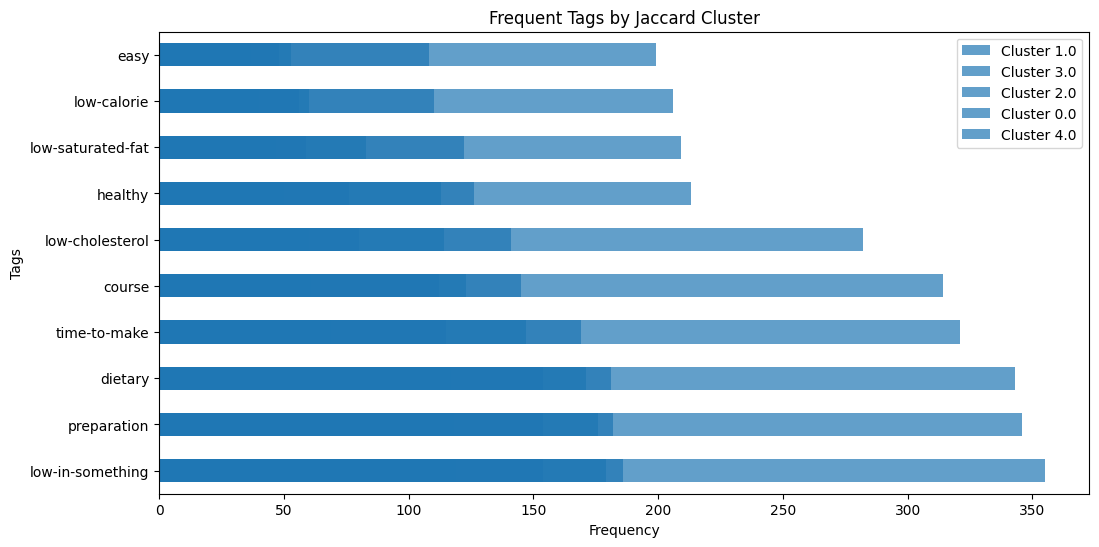

Cluster nan has no tags to plot.


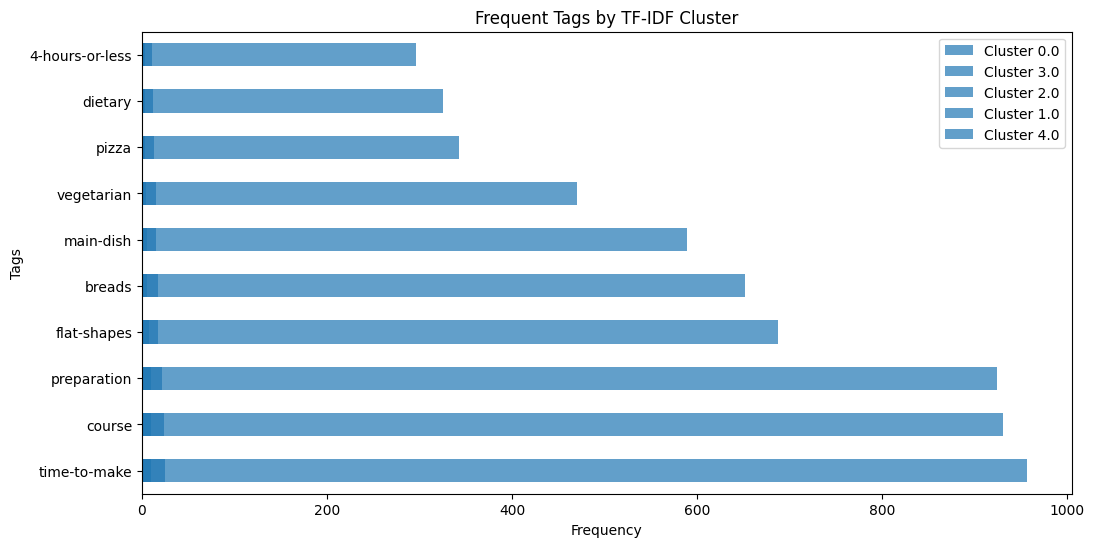

In [39]:
def plot_frequent_tags(tag_results, title):
    plt.figure(figsize=(12, 6))
    for cluster, tags in tag_results.items():
        if not tags.empty:
            tags.plot(kind='barh', label=f'Cluster {cluster}', alpha=0.7)
        else:
            print(f'Cluster {cluster} has no tags to plot.')
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Tags')
    plt.legend()
    plt.show()

print("Jaccard Tags:", jaccard_tags)
print("TF-IDF Tags:", tfidf_tags)

plot_frequent_tags(jaccard_tags, 'Frequent Tags by Jaccard Cluster')
plot_frequent_tags(tfidf_tags, 'Frequent Tags by TF-IDF Cluster')


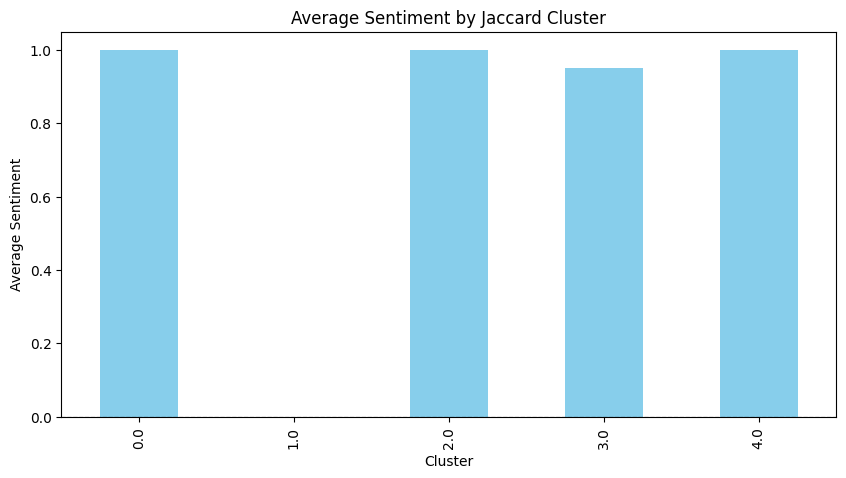

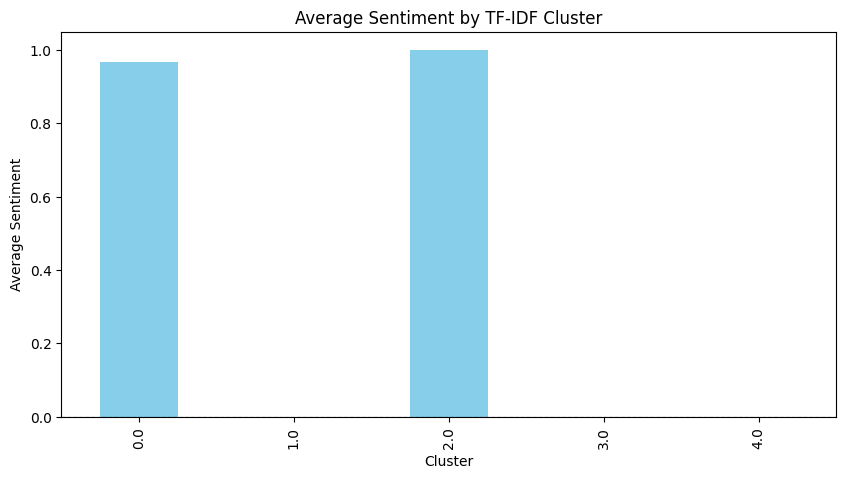

In [40]:
def plot_average_sentiment(avg_sentiment, title):
    plt.figure(figsize=(10, 5))
    avg_sentiment.plot(kind='bar', color='skyblue')
    plt.title(title)
    plt.xlabel('Cluster')
    plt.ylabel('Average Sentiment')
    plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
    plt.show()

# Plot average sentiment for Jaccard clusters
plot_average_sentiment(jaccard_avg_sentiment, 'Average Sentiment by Jaccard Cluster')

# Plot average sentiment for TF-IDF clusters
plot_average_sentiment(tfidf_avg_sentiment, 'Average Sentiment by TF-IDF Cluster')
